In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import mysql
from mysql.connector import connect, Error

In [23]:
cnx = mysql.connector.connect(user=f'{user}', password=f'{password}',
                              host=f'{host}', database=f"{database}")

cursor = cnx.cursor()

In [24]:
query = """
SELECT 
EDS.TWEET_ID,
EDS.EMOTIONS_ALL,
S.KEYWORD,
E.EVENT_NAME
FROM VW_TWEET_EMOTIONS_ALL EDS
JOIN TWEET_DATA TD ON EDS.TWEET_ID = TD.TWEET_ID
JOIN SEARCHES S ON S.SEARCH_ID = TD.SEARCH_ID
JOIN EVENTS E ON E.EVENT_ID = S.EVENT_ID
"""

emotions_all = pd.read_sql(query, cnx)

In [31]:
def sent(df):
    '''
    Input: dataframe from database with emotions in listagg form or by distinct value.
    Output: datafram with positive/negative sentiment association
    '''
    neg_emotions = ['anger', 'disgust', 'fear', 'sadness', 'negative']
    pos_emotions = ['anticipation', 'joy', 'surprise', 'trust', 'positive']

    for ind, row in df.iterrows():
        pos_count = 0
        neg_count = 0
        for emo in row['EMOTIONS_ALL'].split(', '):
            for nsent in neg_emotions:
                if emo == nsent: 
                    neg_count+=1
            for psent in pos_emotions:
                if emo ==psent: 
                    pos_count+=1
        if pos_count > neg_count: df.at[ind, 'sentiment'] = 1
        elif pos_count == neg_count: df.at[ind, 'sentiment'] = 999
        else: df.at[ind,'sentiment'] = 0

    return df

def biserial_setup(df, event):
    '''
    Input: dataframe from database with emotions in listagg form or by distinct value, which will be
    passed to sentiment(). Requires events and keyword searches.
    Output: Aggregated count of tweets by keyword search.
    Parameters: dataframe, event that dataframe will be filtered on
    '''

    df_biserial=sent(df)
    df_biserial = df_biserial[df_biserial['EVENT_NAME']==event]
    df_biserial = df_biserial.groupby(['KEYWORD', 'sentiment']).count()
    df_biserial.reset_index(inplace=True)

    df_biserial = df_biserial[df_biserial['sentiment']!=999]

    return df_biserial

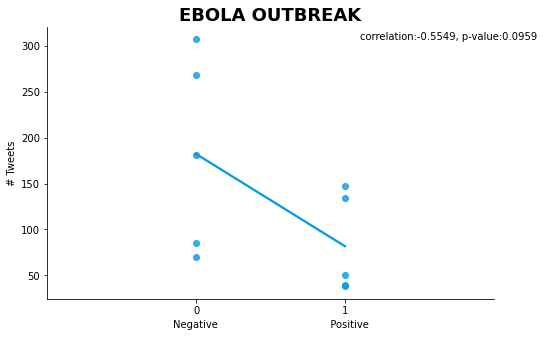

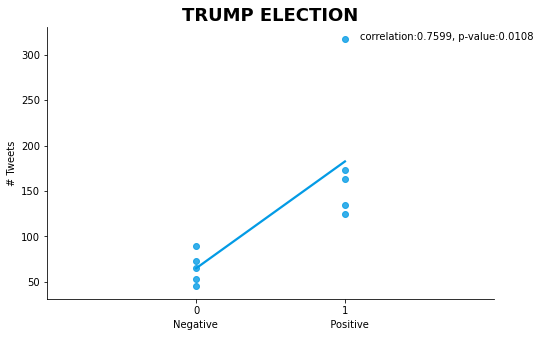

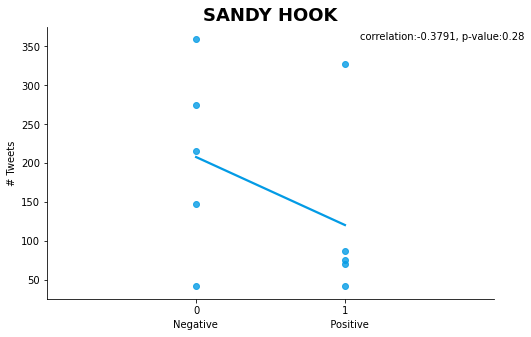

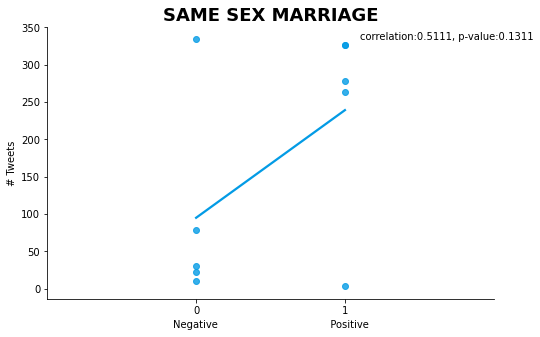

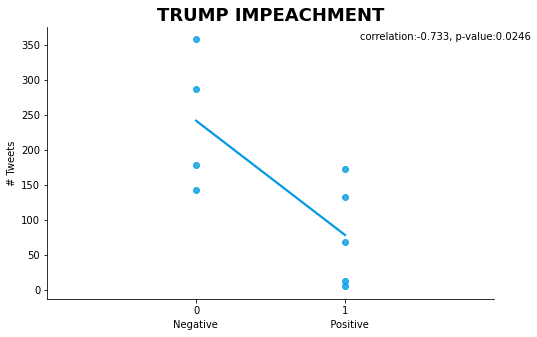

In [40]:
for event in list(emotions_all['EVENT_NAME'].unique()):
    df = biserial_setup(emotions_all, event)

    tweet_id = np.array(df['TWEET_ID'])
    sentiment = np.array(df['sentiment'])

    cc, p = (stats.pointbiserialr(sentiment, tweet_id))
    cc = round(cc,4)
    p = round(p,4)

    fig_dims = (8, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.regplot( y='TWEET_ID', x='sentiment',data=df, color ='#039BE5', ci=False)
    plt.setp(ax,xticks=[-1,2]) 
    ax.set_xlabel('Negative                                    Positive', fontsize = 10) # X label
    ax.set_ylabel('# Tweets') # Y label
    sns.despine(right=True) 
    ax.set(xlim=(-1,2), xticks=[0,1])
    ax.set_title(f"{event}",fontweight="bold", size=18)
    ax.annotate(f'correlation:{cc}, p-value:{p}', (1.1,df['TWEET_ID'].max()))
    fig.savefig(f'../images/point_biserial/pb_{event}.png', dpi=750, bbox_inches='tight')